# Computer Problem Set 4 : The Black-Scholes hedging strategy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Let $T\geq 0$ be a fixed maturity. For a positive integer n, we denote $\Delta T := \frac{T}{n}$, $t_n^i := i \Delta T$, $i=0,...,n$. We consider a Brownian motion W, and we define the process : 
$$ S_t := S_0 e^{(\mu - \frac{\sigma^2}{2})t+  \sigma W_t} , t\geq0 $$
where $\mu \in \mathbb{R}$ and $\sigma >0$ denote the drift and the volatility parameters.

In the context of the Black-Scholes model, the no-arbitrage price of a European call option on an underlying asset with price process ${S_t, t\geq0}$ is given by :

$$ BS(S_0,K,T) := S_0 N(d_{+}(S_0, Ke^{-rT}, \sigma^2 T)) - K e^{-rT} N(d_{-}(S_0, Ke^{-rT}, \sigma^2 T))$$

where r is the instantaneous interest rate, K,T denote the strike and the maturity of the option respectively, and : 

$$ d_{\pm}(s,k,v) := \frac{ln(\frac{s}{k})}{\sqrt{v}} \pm \frac{1}{2} \sqrt{v} $$

The corresponding optimal hedging strategy consists in holding $\Delta_t$ shares of the underlying asset at each time $t$, with :

$$ \Delta_t(K) = Delta(S_t, K, T-t) := N(d_{+}(S_t, K e^{-r(T-t)}, \sigma^2 (T-t))) $$

### Question 1

In [3]:
T=1.5
N=1000
S0=100
sigma=0.3
r=0.05
mu=0.05
n=100

In [4]:
def brownian_motion(n,m):
    dT=T/n
    Z=np.random.randn(m, n)*np.sqrt(dT)
    
    return np.concatenate((np.zeros([m,1]) , np.cumsum(Z, axis=1)), axis=1)

def geometric_brownian(n=n, m=N, S0=S0, mu=mu, sigma=sigma):
    W=brownian_motion(n,m)
    dT=T/n
    return S0*np.exp((mu-0.5*sigma**2)*np.arange(0,n+1)*dT + sigma*W)
    

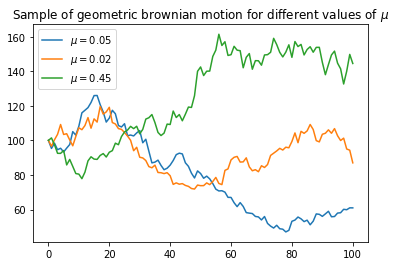

In [5]:
mus=[0.05, 0.02, 0.45]
G=[]
for mu in mus:
    G=geometric_brownian(n,1,S0,mu,sigma)[0]
    plt.plot(G, label='$\mu = $'+str(mu))
plt.title("Sample of geometric brownian motion for different values of $\mu$")
plt.legend()
plt.show()

The mean of $S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t} $ is given by the expression :
\begin{equation}
\begin{split}
 \mathbb{E}(S_t) &= \mathbb{E} (S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma W_t})  \\
 &= S_0 e^{(\mu - \frac{\sigma^2}{2})t} \mathbb{E} (e^{\sigma W_t}) \\
 &= S_0 e^{(\mu - \frac{\sigma^2}{2})t} e^{\frac{\sigma^2}{2}t} \\
 &= S_0 e^{\mu t}
\end{split}
\end{equation}
Since that $\sigma W_t$ has a distribution $N(0,\sigma^2 t)$, we have by using Laplace's tranform : $\mathbb{E} (e^{\sigma W_t}) = e^{\frac{\sigma^2}{2}t}$.
And the variance is $S_t$ is given by :
$$\mathbb{Var} (S_t) = S_0^2 e^{2\mu t} (e^{\sigma^2t} -1)$$

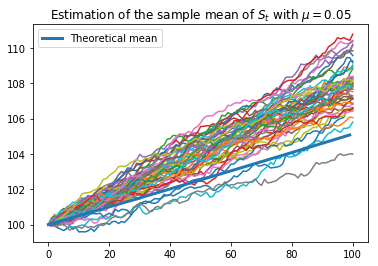

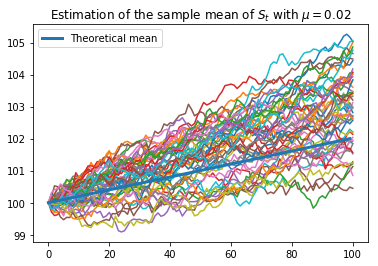

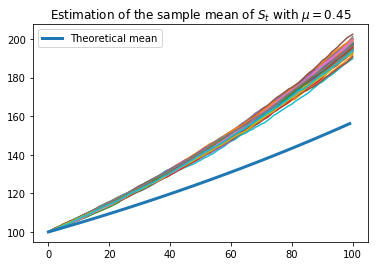

In [6]:
for mu in mus : 
    plt.figure()
    for i in range(50):
        G=geometric_brownian(n,N,S0,mu,sigma)
        plt.plot(np.mean(G, axis=0))
    plt.plot(S0*np.exp(mu*np.arange(0,100)/100), label="Theoretical mean", linewidth=3)
    plt.title("Estimation of the sample mean of $S_t$ with $\mu = $"+str(mu))
    plt.legend()
    
plt.show()

These plots show that the drift $\mu$ has a big impact on the estimation of the mean, since the variance of $S_t$ has an exponential variation in $e^{\mu t}$.

### Question 2

We denote :
$$ e^{-rT} X^n_T(K) := BS(S_0,K,T) + \sum_{i=1}^{n} \Delta_{t^n_{i-1}}(K) (e^{-rt^n_i} S_{t^n_i} - e^{-rt^n_{i-1}} S_{t^n_{i-1}})$$

Let's simulate N=1000 copies of $X^n_T(K)$ with values of $K \in \{100 \pm i, i=0,...,20\}$ and $\mu \in \{0.05, 0.15, 0.45\}$

In [16]:
#let's define phi as the cdf of the normal distribution
def phi(x):
    return (1.0+np.erf(x/np.sqrt(2)))/2.0

def BS(S0,K,T):
    d1=np.log(S0*np.exp(r*T)/K)/(sigma*np.sqrt(T))+0.5*sigma*np.sqrt(T)
    d2=np.log(S0*np.exp(r*T)/K)/(sigma*np.sqrt(T))-0.5*sigma*np.sqrt(T)
    return S0*phi(d1)-K*np.exp(-r*T)*phi(d2)

def delta(St,K,T,t):
    dt=T-t
    d=np.log(St*np.exp(r*dt)/K)/(sigma*np.sqrt(dt))+0.5*sigma*np.sqrt(dt)
    return phi(d)

In [60]:
#the function X below return the values of X_T as well as S_T because we will need it in the following question
def X(n,N,T,K,mu):
    S=np.transpose(geometric_brownian(n,N,S0,mu,sigma))
    times=np.arange(0,n+1)*T/n
    return np.exp(r*T)*(BS(S0,K,T) + np.sum([delta(S[i],K,T,times[i-1])*(np.exp(-r*times[i])*S[i] - np.exp(-r*times[i-1])*S[i-1]) for i in range(1,n+1)], axis=0)), S[-1]

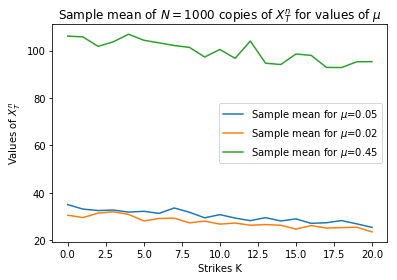

In [148]:
for mu in mus:
    x=[]
    for K in range(100,121):
        x.append(X(n,N,T,K,mu)[0])

    x=np.transpose(x).mean(axis=0)
    
    plt.plot(x, label="Sample mean for $\mu$="+str(mu))
    plt.xlabel("Strikes K")
    plt.ylabel("Values of $X_T^n$")
    plt.legend()
    plt.title("Sample mean of $N=1000$ copies of $X_T^n$ for values of $\mu$")
    
plt.show()

We define the Profit and Loss : 
$$ PL^n_T(K) := X^n_T(K) - (S_T-K)^{+} $$

In [108]:
def PnL(n,N,T,K,mu):
    x=X(n,N,T,K,mu)
    return x[0]-(x[1]-K).clip(0)

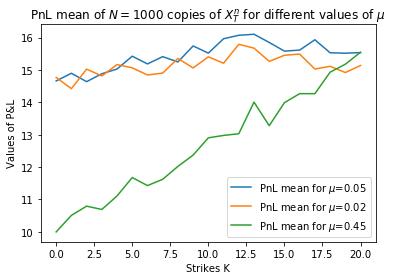

In [147]:
def pnl_mean_std(n,N,T,K_values,mu):
    pnl=[]
    for K in K_values:
        pnl.append(PnL(n,N,T,K,mu))
    
    pnl=np.transpose(pnl)
    pnl_mean=pnl.mean(axis=0)
    pnl_std=pnl.std(axis=0)
    return pnl_mean, pnl_std
    
for mu in mus:
    
    plt.plot(pnl_mean_std(n,N,T,np.arange(100,121),mu)[0], label="PnL mean for $\mu$="+str(mu))
    plt.xlabel("Strikes K")
    plt.ylabel("Values of P&L")
    plt.legend()
    plt.title("PnL mean of $N=1000$ copies of $X_T^n$ for different values of $\mu$")
    
plt.show()

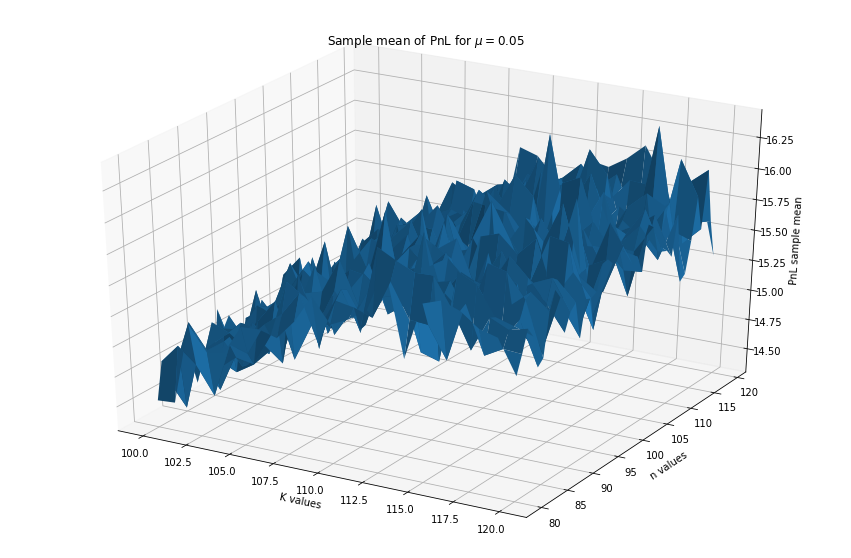

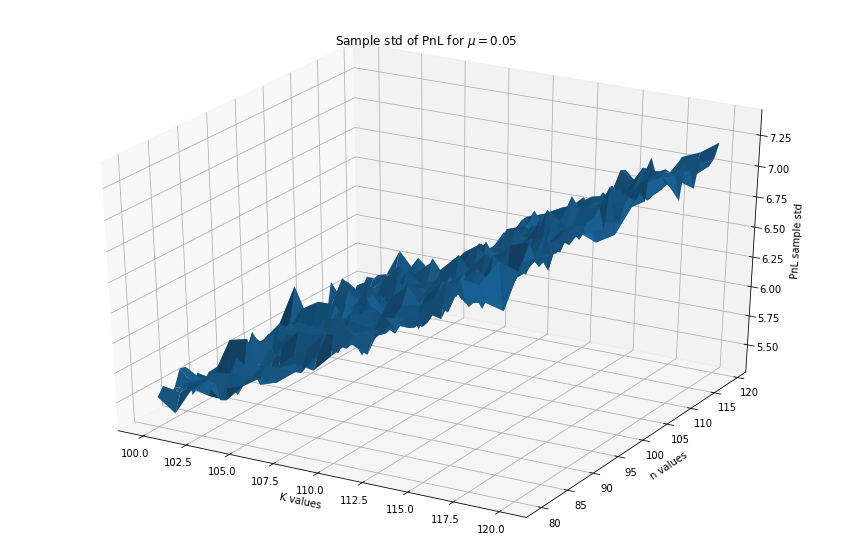

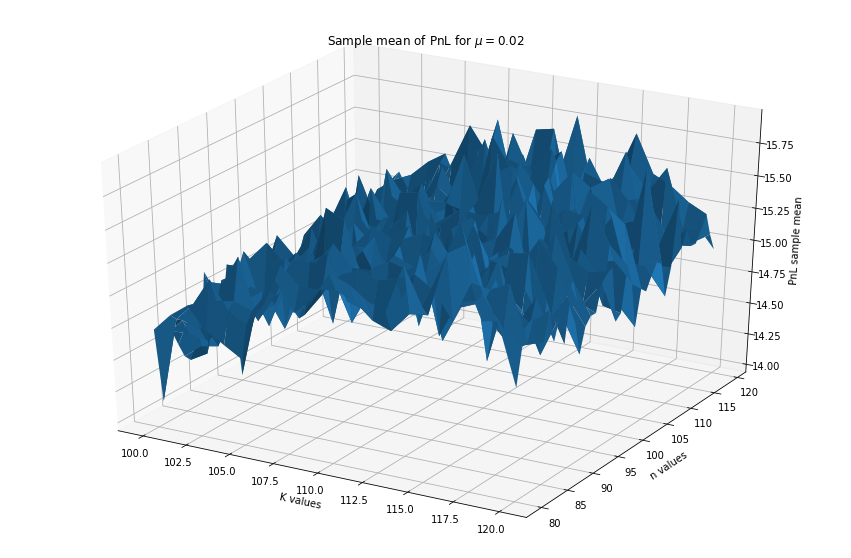

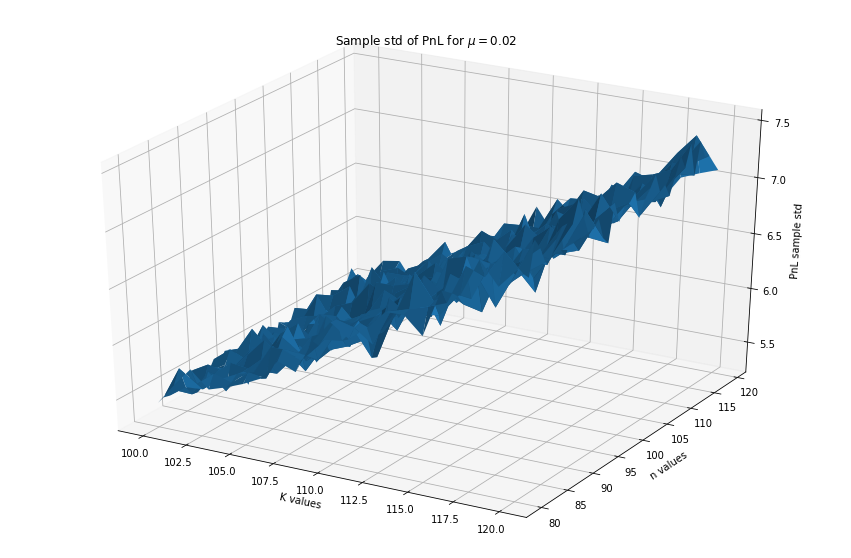

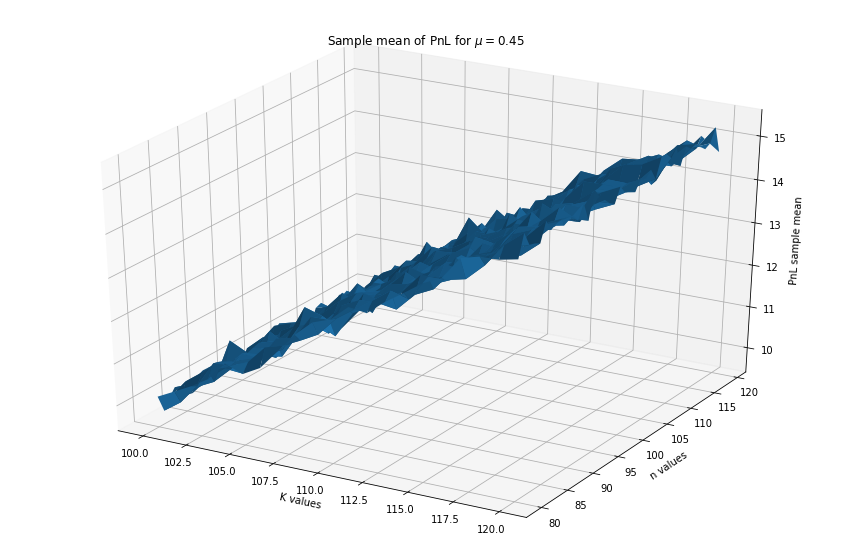

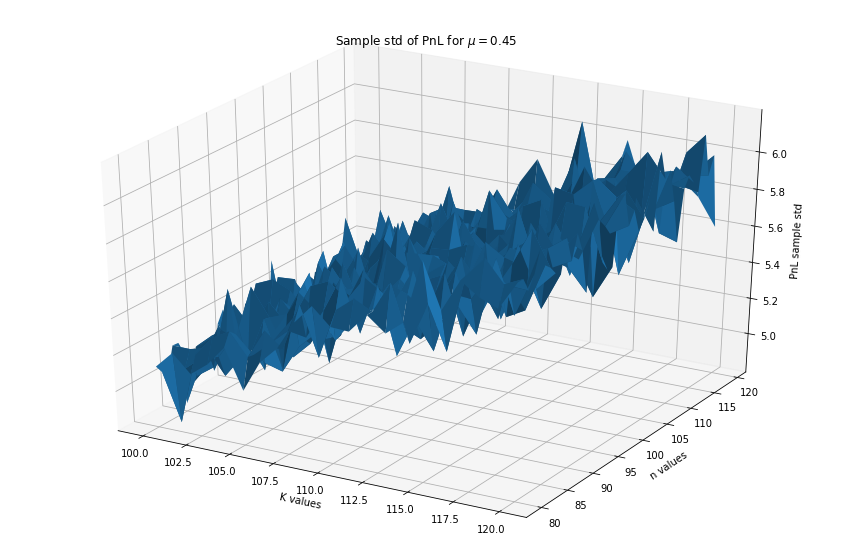

In [143]:
%matplotlib inline

n_values=np.arange(80,120)
K_values=np.arange(100,121)

for mu in mus:

    pnl_mean=[]
    pnl_std=[]
    for n in n_values:
        m,s=pnl_mean_std(n,N,T,K_values,mu)
        pnl_mean.append(m)
        pnl_std.append(s)
        
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')
    x,y=np.meshgrid(n_values, K_values)
    ax = plt.axes(projection='3d')

    ax.plot_surface(y,x, np.transpose(np.matrix(pnl_mean)))
    ax.set_xlabel("K values")
    ax.set_ylabel("n values")
    ax.set_zlabel("PnL sample mean")
    plt.title("Sample mean of PnL for $\mu=$"+str(mu))

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')
    x,y=np.meshgrid(n_values, K_values)
    ax = plt.axes(projection='3d')

    ax.plot_surface(y,x, np.transpose(np.matrix(pnl_std)))
    ax.set_xlabel("K values")
    ax.set_ylabel("n values")
    ax.set_zlabel("PnL sample std")
    plt.title("Sample std of PnL for $\mu=$"+str(mu))

plt.show()